__<span style="background-color:#ffffe0">第5章　時系列データを活用したビジネス事例</span>__

# 5.2　モニタリング指標の異常検知と要因探索（小売りチェーン）

## ステップ1：準備

### 必要なモジュールの読み込み

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd

from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

### データセットの読み込み

In [2]:
#
# 必要なデータセットの読み込み
#

dataset = 'chap5_2.csv'
df=pd.read_csv(dataset)

print(df) #確認

           date day_of_the_week       y1  y21   y22    x1    x2     x3    x4   
0      2016/6/6             Mon   818979  177  4627  18.3   0.0  0.006     0  \
1      2016/6/7             Tue   789332  164  4813  19.8   0.9  0.002     0   
2      2016/6/8             Wed   793266  141  5626  22.8   0.5  0.002     0   
3      2016/6/9             Thu   721415  157  4595  23.1   7.0  0.005     0   
4     2016/6/10             Fri   796138  146  5453  22.2   0.0  0.003     0   
..          ...             ...      ...  ...   ...   ...   ...    ...   ...   
136  2016/10/20             Thu   799006  158  5052  20.8   0.0  0.002     0   
137  2016/10/21             Fri   822875  145  5687  17.8   0.5  0.007     0   
138  2016/10/22             Sat  1326138  142  9433  17.7  82.9  0.229  7500   
139  2016/10/23             Sun  1392365  155  9087  16.9  76.5  0.225  7500   
140  2016/10/24             Mon   689187  107  6403  17.3  10.8  0.010     0   

     holiday  
0          0  
1        

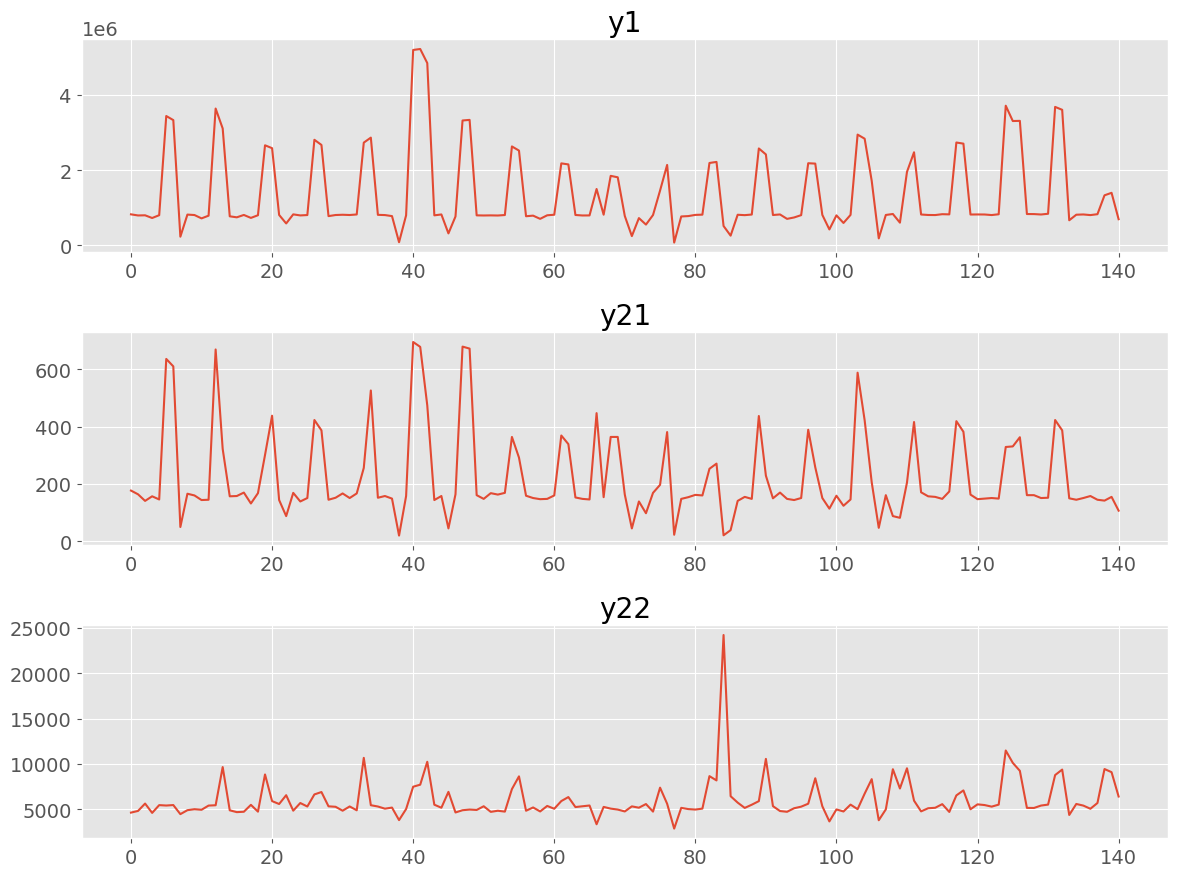

In [3]:
#
# グラフ（y1 売上, y21 客数, y22 客単価）
#

fig, ax = plt.subplots(3, 1, tight_layout=True)

for i in range(3):
    ax[i].plot(df.index, df.iloc[:,i+2])
    ax[i].set_title(df.columns[i+2])

plt.show()

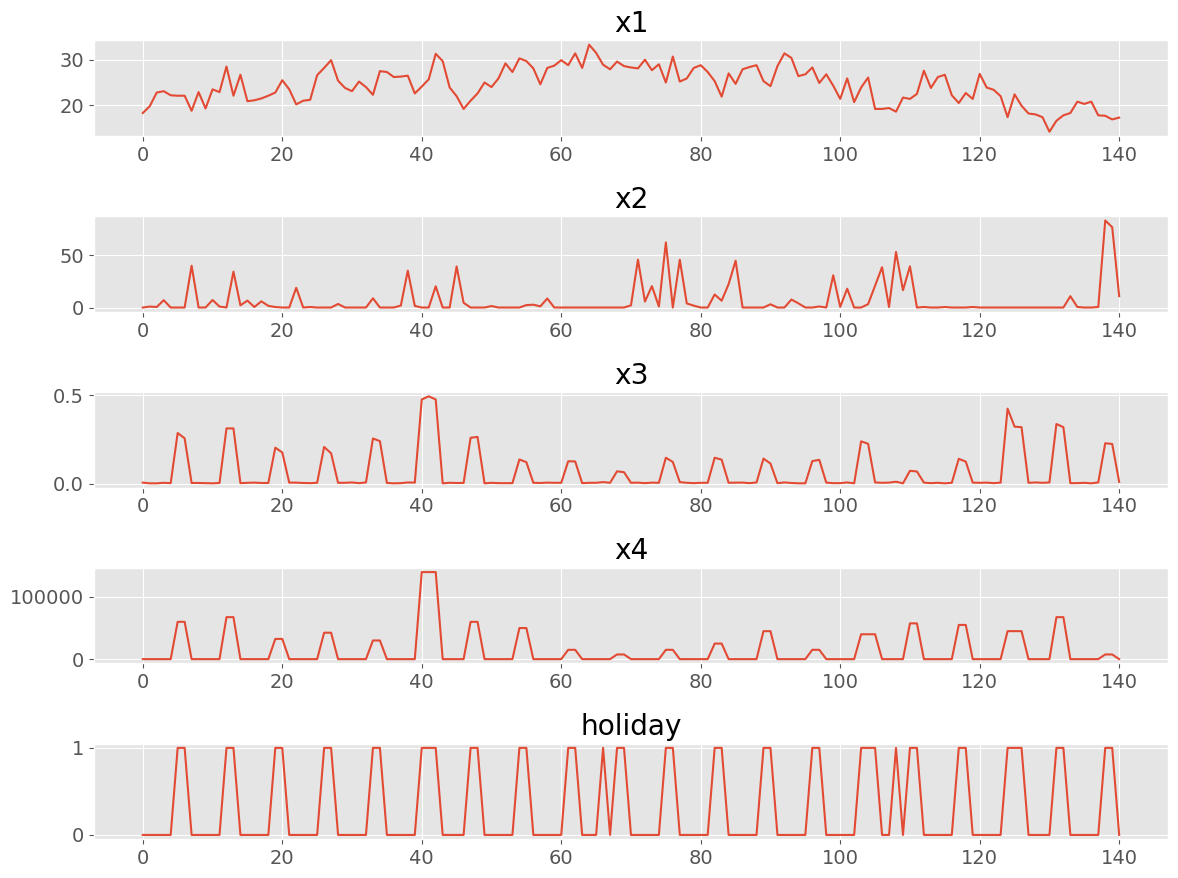

In [4]:
#
# グラフ（x1 気温, x2 降水量, x3 値引き率, x4 チラシ配布量, holiday 休日）
#

fig, ax = plt.subplots(5, 1, tight_layout=True)

for i in range(5):
    ax[i].plot(df.index, df.iloc[:,i+5])
    ax[i].set_title(df.columns[i+5])

plt.show()

### モデル構築用データと評価対象データ（直近7日間）に分割

In [5]:
#
# データセットをモデル構築用データと評価対象データ（直近７日間）に分割
#

target_length = 7

df_train, df_target = train_test_split(
    df,test_size=target_length)

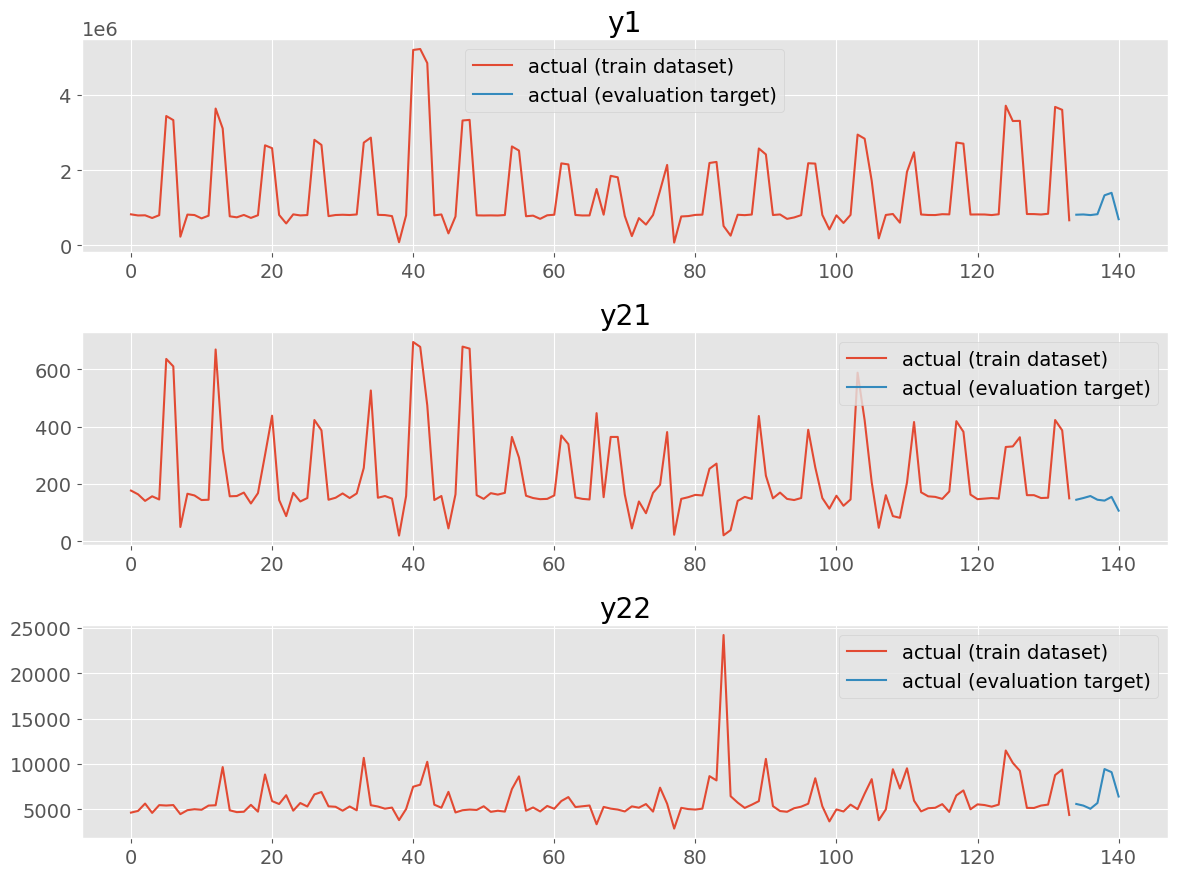

In [6]:
#
# グラフ（y1 売上, y21 客数, y22 客単価）
#

fig, ax = plt.subplots(3, 1, tight_layout=True)

for i in range(3):
    ax[i].plot(
        df_train.index, 
        df_train.iloc[:,i+2], 
        label="actual (train dataset)")
    ax[i].plot(
        df_target.index, 
        df_target.iloc[:,i+2], 
        label="actual (evaluation target)")
    ax[i].set_title(df.columns[i+2])
    ax[i].legend()

plt.show()

### モニタリング指標の異常検知用の関数定義

In [7]:
#
# 関数定義
#

'''
関数名:
    anomaly_detection
引数:
    train_y　モデル構築用データ（NumPy配列）の目的変数y
    target_y　評価対象データ（NumPy配列）の目的変数y
    train_X　モデル構築用データ（NumPy配列）の説明変数X
    target_X　評価対象データ（NumPy配列）の説明変数X
    seasonal_m　周期（周期なしのとき0と設定）
戻値（PandasのDataFrameとして返す）：
    train_result　モデル構築用データの期間の外れ値スコアなどの結果集約
    target_result　評価対象データの期間の外れ値スコアなどの結果集約
　変数（戻値として出力されるデータフレームの変数）：
    y　実測値
    pred　予測値
    residual　残差
    std_res　標準化残差
    abs_std_res　外れ値スコア（標準化残差の絶対値）
'''

def anomaly_detection(train_y, target_y, train_X, target_X, seasonal_m):
    
    # 予測モデルの学習（モデル構築用データ利用）
    if seasonal_m > 0:
        arima_model = auto_arima(
            train_y,
            X=train_X, 
            seasonal=True, 
            m=seasonal_m)
    else:
        arima_model = auto_arima(
            train_y, 
            X=train_X, 
            seasonal=False)
    
    # 残差（モデル構築用データの期間）
    train_pred = arima_model.predict_in_sample(X=train_X)
    train_res = train_y[seasonal_m:]-train_pred[seasonal_m:]
    
    # 残差を標準化するモデルの学習
    scaler = StandardScaler().fit(train_res.reshape(-1, 1))
    
    # 標準化残差（モデル構築用データの期間）
    train_res_ss = scaler.transform(train_res.reshape(-1, 1))
    
    # モデル構築用データの期間の外れ値スコアなどの結果集約
    train_result = pd.DataFrame(
        np.concatenate(
            [train_y[seasonal_m:].reshape(-1, 1),
             train_pred[seasonal_m:].reshape(-1, 1),
             train_res.reshape(-1, 1),
             train_res_ss,
             abs(train_res_ss)],
            axis=1),
        columns = ['y','pred','residual','std_res','abs_std_res'])
    
    # 残差（評価対象データの期間）
    target_pred = arima_model.predict(
        n_periods=len(target_y),X=target_X)
    target_res = target_y-target_pred
    
    # 標準化残差（評価対象データの期間）
    target_res_ss = scaler.transform(target_res.reshape(-1, 1))
    
    # 評価対象データの期間の外れ値スコアなどの結果集約
    target_result = pd.DataFrame(
        np.concatenate(
            [target_y.reshape(-1, 1),
             target_pred.reshape(-1, 1),
             target_res.reshape(-1, 1),
             target_res_ss,
             abs(target_res_ss)],
            axis=1),
        columns = ['y','pred','residual','std_res','abs_std_res'])
    
    # 戻り値
    return train_result, target_result

## ステップ2：売上（y1）の異常検知

In [8]:
#
# 売上（y1）の異常検知
#

# 引数設定
seasonal_m = 7
train_y = df_train.y1.values
target_y = df_target.y1.values
train_X = df_train.holiday.values.reshape(-1, 1)
target_X = df_target.holiday.values.reshape(-1, 1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y, 
    target_y, 
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.124626
1    0.289900
2    0.679430
3    0.371815
4    3.759694
5    3.563634
6    0.044867
Name: abs_std_res, dtype: float64


## ステップ3：客数（y21）と客単価（y22）の異常検知

In [9]:
#
# 客数（y21）の異常検知
#

# 引数設定
seasonal_m = 7
train_y = df_train.y21.values
target_y = df_target.y21.values
train_X = df_train.holiday.values.reshape(-1, 1)
target_X = df_target.holiday.values.reshape(-1, 1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y, 
    target_y, 
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.082814
1    0.134805
2    0.221831
3    0.026475
4    2.978925
5    2.824350
6    0.444772
Name: abs_std_res, dtype: float64


In [10]:
#
# 客単価（y22）の異常検知
#

# 引数設定
seasonal_m = 7
train_y = df_train.y22.values
target_y = df_target.y22.values
train_X = df_train.holiday.values.reshape(-1, 1)
target_X = df_target.holiday.values.reshape(-1, 1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y, 
    target_y, 
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.121857
1    0.034978
2    0.133469
3    0.173018
4    0.964427
5    0.797427
6    0.518601
Name: abs_std_res, dtype: float64


## ステップ4：客数（y21）と関係している説明変数Xの探索（要因探索）

### 説明変数の全てを利用しPLS回帰

In [11]:
#
# 利用する目的変数yと説明変数Xの設定
#

# 利用データ
## 目的変数y
train_y = df_train[['y21']]
## 説明変数X
train_X = df_train.iloc[:,5:]

# 標準化
## 目的変数y
train_X_ss = StandardScaler().fit_transform(train_X)
## 説明変数X
train_y_ss = StandardScaler().fit_transform(train_y)

In [12]:
#
# PLS回帰モデルの学習
#

# モデルのインスタンス生成
PLS_model = PLSRegression()

# 学習
PLS_model.fit(train_X_ss, train_y_ss)

# R2（決定係数）
print('R2:\n',PLS_model.score(train_X_ss, train_y_ss))
print('-----------------------------------')

# 標準偏回帰係数の出力
print('partial regression coefficient:\n',PLS_model.coef_)

R2:
 0.8489131723965102
-----------------------------------
partial regression coefficient:
 [[ 0.06169952]
 [-0.28340146]
 [ 0.3064518 ]
 [ 0.2969531 ]
 [ 0.32658263]]


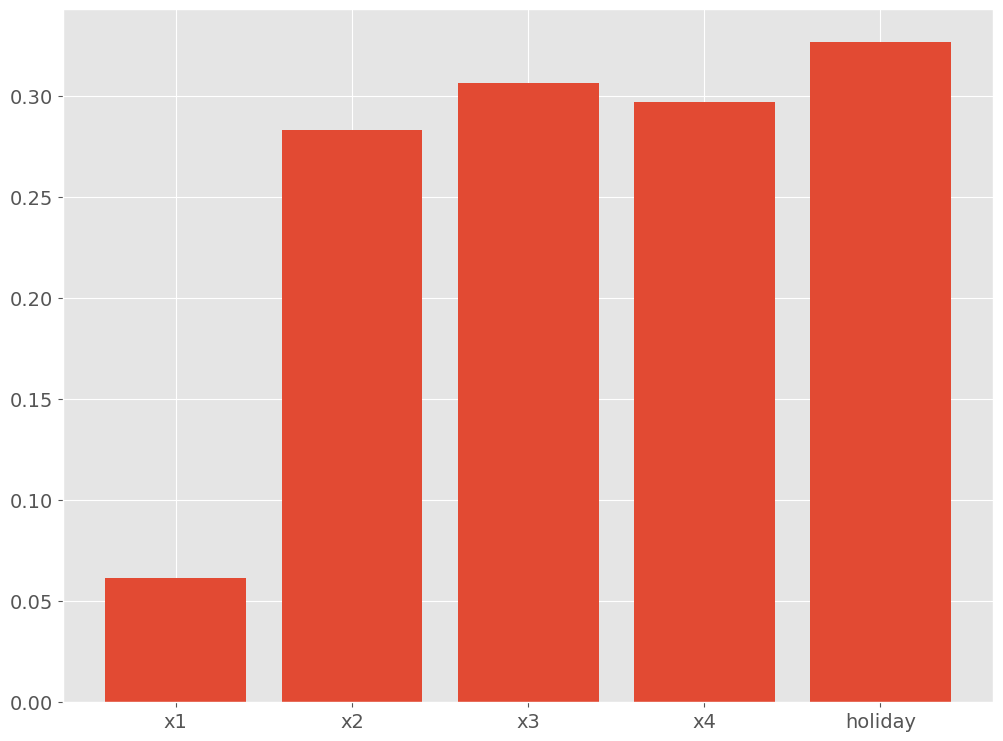

In [13]:
#
# グラフ化（偏回帰係数の絶対値）
#

plt.bar(
    np.array([1, 2, 3, 4, 5]),
    abs(PLS_model.coef_)[:,0],
    tick_label=train_X.columns)

plt.show()

In [14]:
#
# ローディング
#

print('x_loadings:\n',PLS_model.x_loadings_)
print('-----------------------------------')
print('y_loadings:\n',PLS_model.y_loadings_)

x_loadings:
 [[-0.00975085 -0.38697188]
 [-0.09670663  0.91557648]
 [ 0.59589887  0.11074084]
 [ 0.58446419  0.13830854]
 [ 0.55640274  0.11384218]]
-----------------------------------
y_loadings:
 [[ 0.56257838 -0.17052506]]


### 説明変数からx1を除外しPLS回帰

In [15]:
#
# PLS回帰モデルの学習
#

# x1除外
train_X_ss_del = np.delete(train_X_ss, 0, 1)

# モデルのインスタンス生成
PLS_model = PLSRegression()

# 学習
PLS_model.fit(train_X_ss_del, train_y_ss)

# R2（決定係数）
print('R2:\n',PLS_model.score(train_X_ss_del, train_y_ss))
print('-----------------------------------')

# 標準偏回帰係数の出力
print('partial regression coefficient:\n',PLS_model.coef_)

R2:
 0.8478675709830844
-----------------------------------
partial regression coefficient:
 [[-0.29783558]
 [ 0.30401144]
 [ 0.29460953]
 [ 0.32739234]]


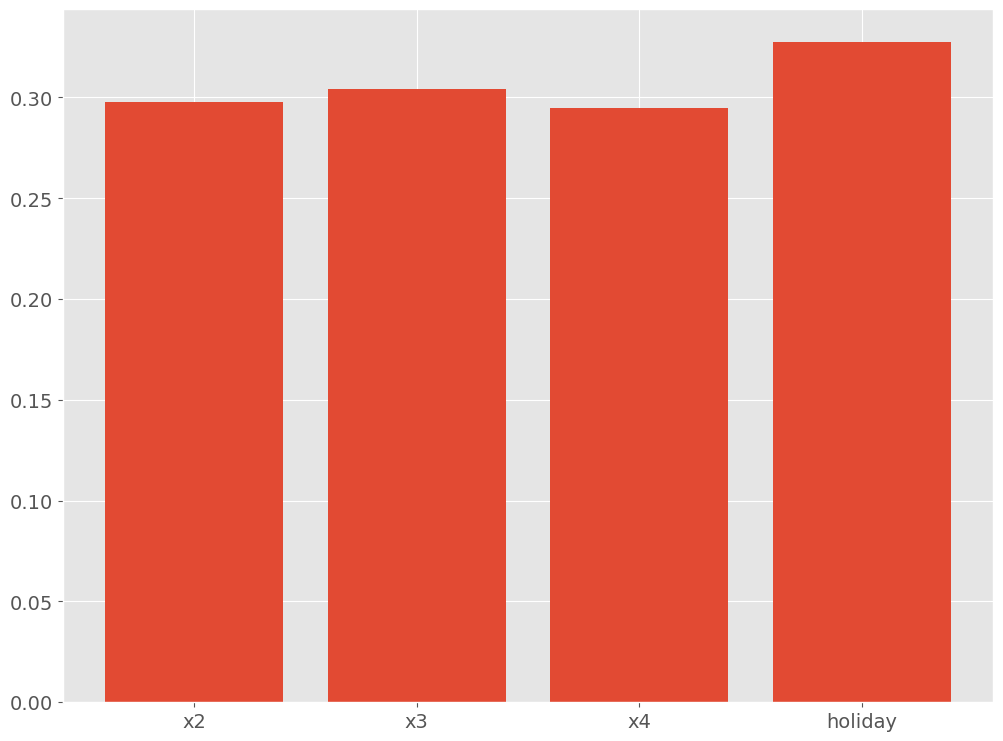

In [16]:
# 
# グラフ化（偏回帰係数の絶対値）
# 

plt.bar(
    np.array([1, 2, 3, 4,]),
    abs(PLS_model.coef_)[:,0],
    tick_label=train_X.columns[1:])

plt.show()

In [17]:
#
# ローディング
#

print('x_loadings:\n',PLS_model.x_loadings_)
print('-----------------------------------')
print('y_loadings:\n',PLS_model.y_loadings_)

x_loadings:
 [[-0.09538366  0.98957113]
 [ 0.59599211  0.10523172]
 [ 0.58438644  0.14161273]
 [ 0.55590393  0.12725228]]
-----------------------------------
y_loadings:
 [[ 0.56165404 -0.17868547]]


## ステップ5：降水量（x2）と値引き率（x3）、チラシ配布量（x4）の異常検知

In [21]:
#
# 降水量（x2）の異常検知
#

# 引数設定
seasonal_m = 0
train_y = df_train.x2.values
target_y = df_target.x2.values
train_X = df_train.holiday.values.reshape(-1, 1)
target_X = df_target.holiday.values.reshape(-1, 1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y, 
    target_y, 
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.335238
1    0.621435
2    0.467062
3    0.497116
4    6.468238
5    5.914739
6    0.397801
Name: abs_std_res, dtype: float64


In [22]:
#
# 値引き率（x3）の異常検知
#

# 引数設定
seasonal_m = 0
train_y = df_train.x3.values
target_y = df_target.x3.values
train_X = df_train.holiday.values.reshape(-1, 1)
target_X = df_target.holiday.values.reshape(-1, 1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y, 
    target_y, 
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    0.042327
1    0.002564
2    0.040504
3    0.044004
4    0.600228
5    0.535583
6    0.095370
Name: abs_std_res, dtype: float64


In [23]:
#
# チラシ配布量（x4）の異常検知
#

# 引数設定
seasonal_m = 0
train_y = df_train.x4.values
target_y = df_target.x4.values
train_X = df_train.holiday.values.reshape(-1, 1)
target_X = df_target.holiday.values.reshape(-1, 1)

# 関数実行
train_result, target_result = anomaly_detection(
    train_y, 
    target_y, 
    train_X,
    target_X,
    seasonal_m)

# 評価対象データの期間の外れ値スコアの確認
print(target_result.abs_std_res)

0    1.859299e-10
1    1.859298e-10
2    1.859298e-10
3    1.859298e-10
4    2.517872e+00
5    2.517872e+00
6    1.859298e-10
Name: abs_std_res, dtype: float64
